In [1]:
import torch
import core.tensor as t
import core.node as n
import core.functions as f
from graphviz import Digraph

In [2]:
t1 = t.Tensor(torch.tensor([[1, 2], [3, 4]]))
t2 = t.Tensor(torch.tensor([[4, 3], [2, 1]]))

t3 = t1 + t2


In [3]:
print(t1)
print(t2)
print(t3)

Tensor1
-------------
tensor([[1, 2],
        [3, 4]])
-------------
None
Tensor2
-------------
tensor([[4, 3],
        [2, 1]])
-------------
None
Tensor3
-------------
tensor([[5, 5],
        [5, 5]])
-------------
None


In [4]:
def draw_dot(roots: list[n.Node]):
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='10',
                     ranksep='0.1',
                     height='0.2',
                     fontname='monospace')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12", rankdir='TB'))
    visited = set[n.Node]()
    accumulators = set[f.GradientAccumulator]()
    functionsAndBackwards = set()

    for root in roots:
        dot.node(name=str(root), label=str(root))

    def build(nodes: set[n.Node]):
        if not nodes:
            return
        
        nextNodes = set[n.Node]()
        for node in nodes:
            if node in visited:
                continue

            if isinstance(node, f.GradientAccumulator):
                accumulators.add(node)
            elif isinstance(node, f.Function):
                functionsAndBackwards.add((node, node.backFn))
                
            visited.add(node)
            for next in node.nextNodes:
                nextNodes.add(next)

                dot.node(name=str(next), label=str(next))
                dot.edge(str(node), str(next))

        build(nextNodes)

    build(roots)

    with dot.subgraph(name='accumulators') as sub:
        sub.attr(rank='same')
        for acc in accumulators:
            for next in acc.nextNodes:
                sub.node(name=str(next), label=str(next))
                sub.node(name=str(acc), label=str(acc))

    for i, (func, backwards) in enumerate(functionsAndBackwards):
        with dot.subgraph(name=f'functionsAndBackwards{i}') as sub:
            sub.attr(rank='same')
            sub.node(name=str(func), label=str(func))
            sub.node(name=str(backwards), label=str(backwards))

    return dot

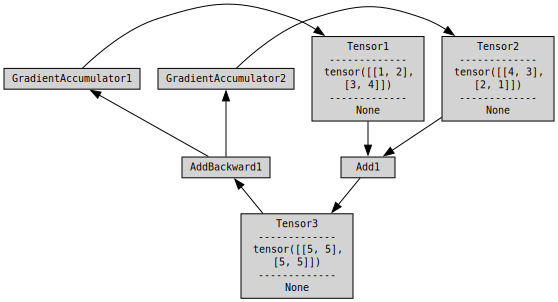

In [5]:
draw_dot([t1, t2])

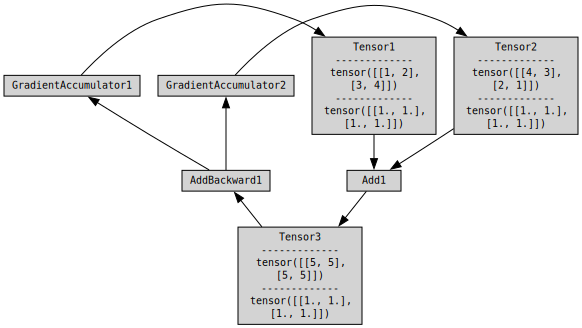

In [6]:
t3.backwards(torch.tensor(1.0))
draw_dot([t1, t2])

In [7]:
t4 = t.Tensor(torch.tensor([[1, 1], [1, 1]]))
t5 = t3 + t4
t6 = t5 + t2

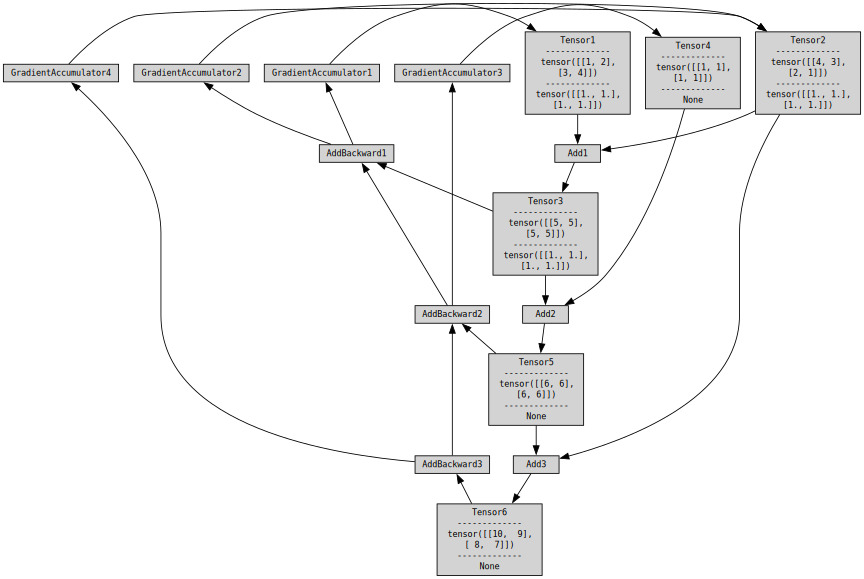

In [8]:
draw_dot([t1, t2, t4])

In [9]:
t6.backwards(torch.tensor([1.0]))


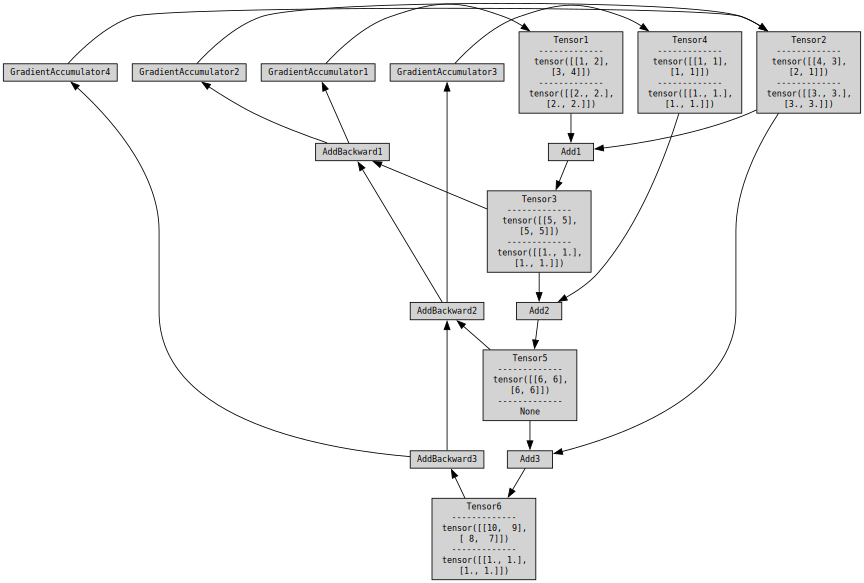

In [10]:
draw_dot([t1, t2, t4])

In [11]:
w = t.Tensor(torch.rand(1, 2), name='w')
b = t.Tensor(torch.rand(1, 1), name='b')

x = t.Tensor(torch.rand(2, 2), name='x')

wx = w @ x
wxb = wx + b
l = wxb.tanh()

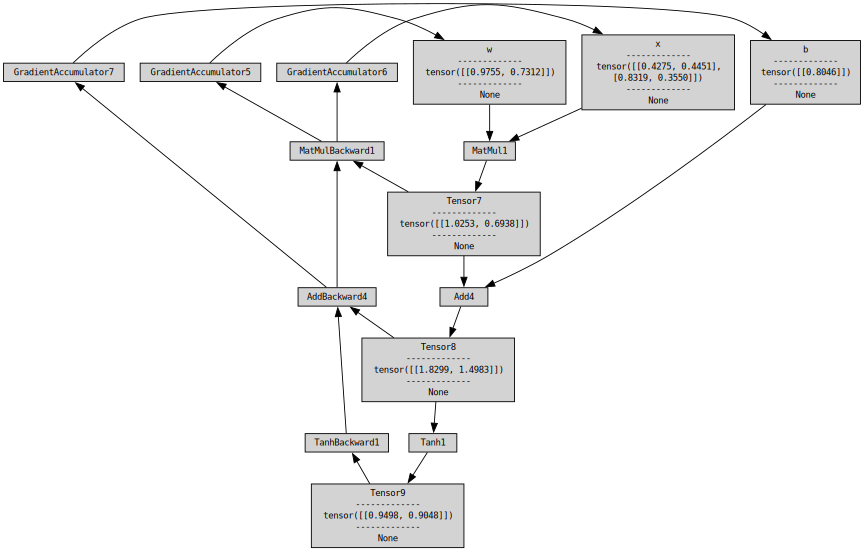

In [12]:
draw_dot([w, x, b])

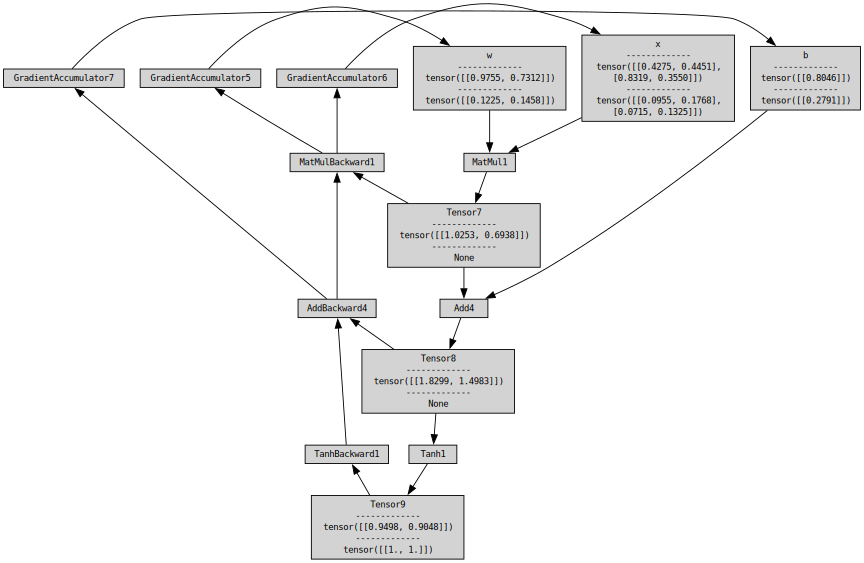

In [13]:
l.backwards(torch.ones(l.data.shape))
draw_dot([w, x, b])

In [14]:
w_torch = torch.clone(w.data)
w_torch.requires_grad = True
w_torch.retain_grad()

b_torch = torch.clone(b.data)
b_torch.requires_grad = True
b_torch.retain_grad()

x_torch = torch.clone(x.data)

wx_torch = w_torch @ x_torch
wxb_torch = wx_torch + b_torch

l_torch = wxb_torch.tanh()
l_torch.retain_grad()

print('w_torch:', w_torch)
print('b_torch:', b_torch)
print('l_torch:', l_torch)

w_torch: tensor([[0.9755, 0.7312]], requires_grad=True)
b_torch: tensor([[0.8046]], requires_grad=True)
l_torch: tensor([[0.9498, 0.9048]], grad_fn=<TanhBackward0>)


In [15]:
l_torch.backward(torch.ones(l_torch.shape), retain_graph=True)

In [16]:
print('w_torch grad:', w_torch.grad)
print('b_torch grad:', b_torch.grad)
print('l_torch grad:', l_torch.grad)

w_torch grad: tensor([[0.1225, 0.1458]])
b_torch grad: tensor([[0.2791]])
l_torch grad: tensor([[1., 1.]])
